# Week 4 — Compact Regression Analysis
Minimal, readable code: load → baseline → find outliers → handle → refit.

In [1]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

path = 'dataset_for-week_4_materials.csv'
df = pd.read_csv(path)
df.head(), df.shape


(   feature1  feature2  feature3   target
 0    62.143  1049.160    -1.062  236.259
 1    35.671    29.771    -0.529   86.480
 2    68.829  1497.475    -0.877  301.332
 3    56.092   682.589    -0.094  202.900
 4     8.440   467.033    -1.758   73.240,
 (120, 4))

In [2]:

def fitX(Xcols, data=None):
    d = df if data is None else data
    X = sm.add_constant(d[Xcols]); y = d['target']
    m = sm.OLS(y, X).fit()
    rmse = np.sqrt(((m.fittedvalues - y)**2).mean())
    return m, rmse

m1, rmse1 = fitX(['feature1'])          # simple
m2, rmse2 = fitX(['feature1','feature2'])  # better (captures curvature)
print({'simple_R2': round(m1.rsquared,3),'simple_RMSE': round(rmse1,2),
       'multi_R2': round(m2.rsquared,3),'multi_RMSE': round(rmse2,2)})


{'simple_R2': 0.806, 'simple_RMSE': 42.64, 'multi_R2': 0.986, 'multi_RMSE': 11.61}


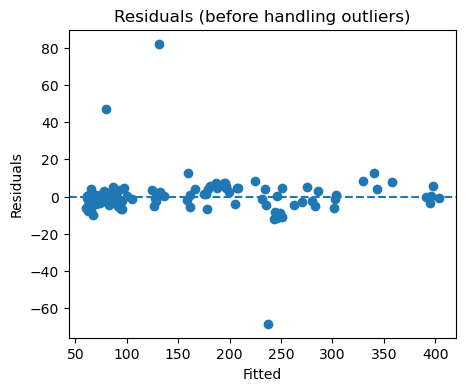

In [3]:

plt.figure(figsize=(5,4))
plt.scatter(m2.fittedvalues, m2.resid)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted'); plt.ylabel('Residuals'); plt.title('Residuals (before handling outliers)')
plt.show()


In [4]:

infl = m2.get_influence()
cooks = infl.cooks_distance[0]
thr = 4/len(df)  # common rule of thumb
out_idx = np.where(cooks > thr)[0]
print('Threshold:', round(thr,4), ' | n_outliers:', len(out_idx), '\nIndices:', out_idx.tolist())
df.loc[out_idx].head()


Threshold: 0.0333  | n_outliers: 3 
Indices: [62, 63, 74]


,feature1,feature2,feature3,target
62,45.654,258.097,1.727,213.843
63,61.435,990.347,-1.534,168.744
74,5.606,591.239,1.744,126.567


In [5]:

df_clean = df.drop(index=out_idx)
m3, rmse3 = fitX(['feature1','feature2'], data=df_clean)
print({'clean_R2': round(m3.rsquared,3), 'clean_RMSE': round(rmse3,2), 'rows_removed': len(out_idx)})


{'clean_R2': 0.998, 'clean_RMSE': 4.53, 'rows_removed': 3}


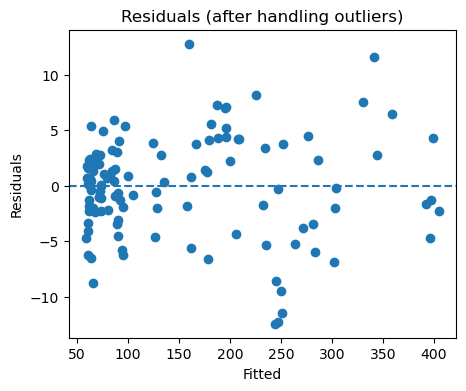

In [6]:

plt.figure(figsize=(5,4))
plt.scatter(m3.fittedvalues, df_clean['target']-m3.fittedvalues)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted'); plt.ylabel('Residuals'); plt.title('Residuals (after handling outliers)')
plt.show()


In [7]:

df_clean = df_clean.assign(f12 = np.sqrt(np.maximum(df_clean['feature2'],0))*df_clean['feature1'] )
m4, rmse4 = fitX(['feature1','feature2','f12'], data=df_clean)
print({'with_interaction_R2': round(m4.rsquared,3), 'with_interaction_RMSE': round(rmse4,2)})
m4.params.round(3)


{'with_interaction_R2': 0.998, 'with_interaction_RMSE': 4.53}


const       5.954
feature1    2.219
feature2    0.101
f12        -0.002
dtype: float64